In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.3, palette='Set2')

%matplotlib inline

---
### Задача 1

С помощью формулы для MDE оцените количество пользователей, на которых нужно выкатить новую модель, чтобы задетектировать увеличение средней суммы покупок пользователя за апрель-май на 150 у.е..

In [3]:
data = pd.read_excel('Online Retail.xlsx')
X = data.drop(['InvoiceNo', 'StockCode', 'Description', 'Country'], axis=1)
X_april_may = X[X.InvoiceDate.apply(lambda x: x.month == 4 or x.month == 5)]

In [11]:
X_april_may['Sum'] = X_april_may['UnitPrice'] * X_april_may['Quantity']
grouped = X_april_may.groupby('CustomerID')['Sum'].sum()
grouped = pd.DataFrame(grouped)
grouped

,Sum
CustomerID,
12347.0,636.25
12348.0,367.00
12353.0,89.00
12354.0,1079.40
12355.0,459.40
...,...
18263.0,307.60
18270.0,-44.20
18272.0,966.74


Формула для MDE (в случае правосторонней альтернативы) утверждает, что минимальный размер выборки $n = \frac{(z_{1-\alpha} + z_{\beta})^2 (\sigma_1 ^2 + \sigma_2 ^2)}{\epsilon^2}$. В данном случае $\epsilon = 150, \alpha = 0.05, \beta = 0.8$, дисперсию же надо оценить по историческим данным

In [12]:
eps = 150
alpha = 0.05
beta = 0.8

In [24]:
variance = np.array(grouped['Sum']).var()
variance

2259252.0536931334

In [18]:
n = (sps.norm.ppf(1 - alpha) + sps.norm.ppf(beta)) ** 2 * 2 * variance / eps ** 2
n

1242.3828272092228

Вот такой большой размер. Забавно, что нам не хватит пользователей, чтобы разделить их на две группы такого размера, так как всего их 1579 < 1242 * 2

---
### Задача 2

Выведите формулу MDE для относительного t-теста.

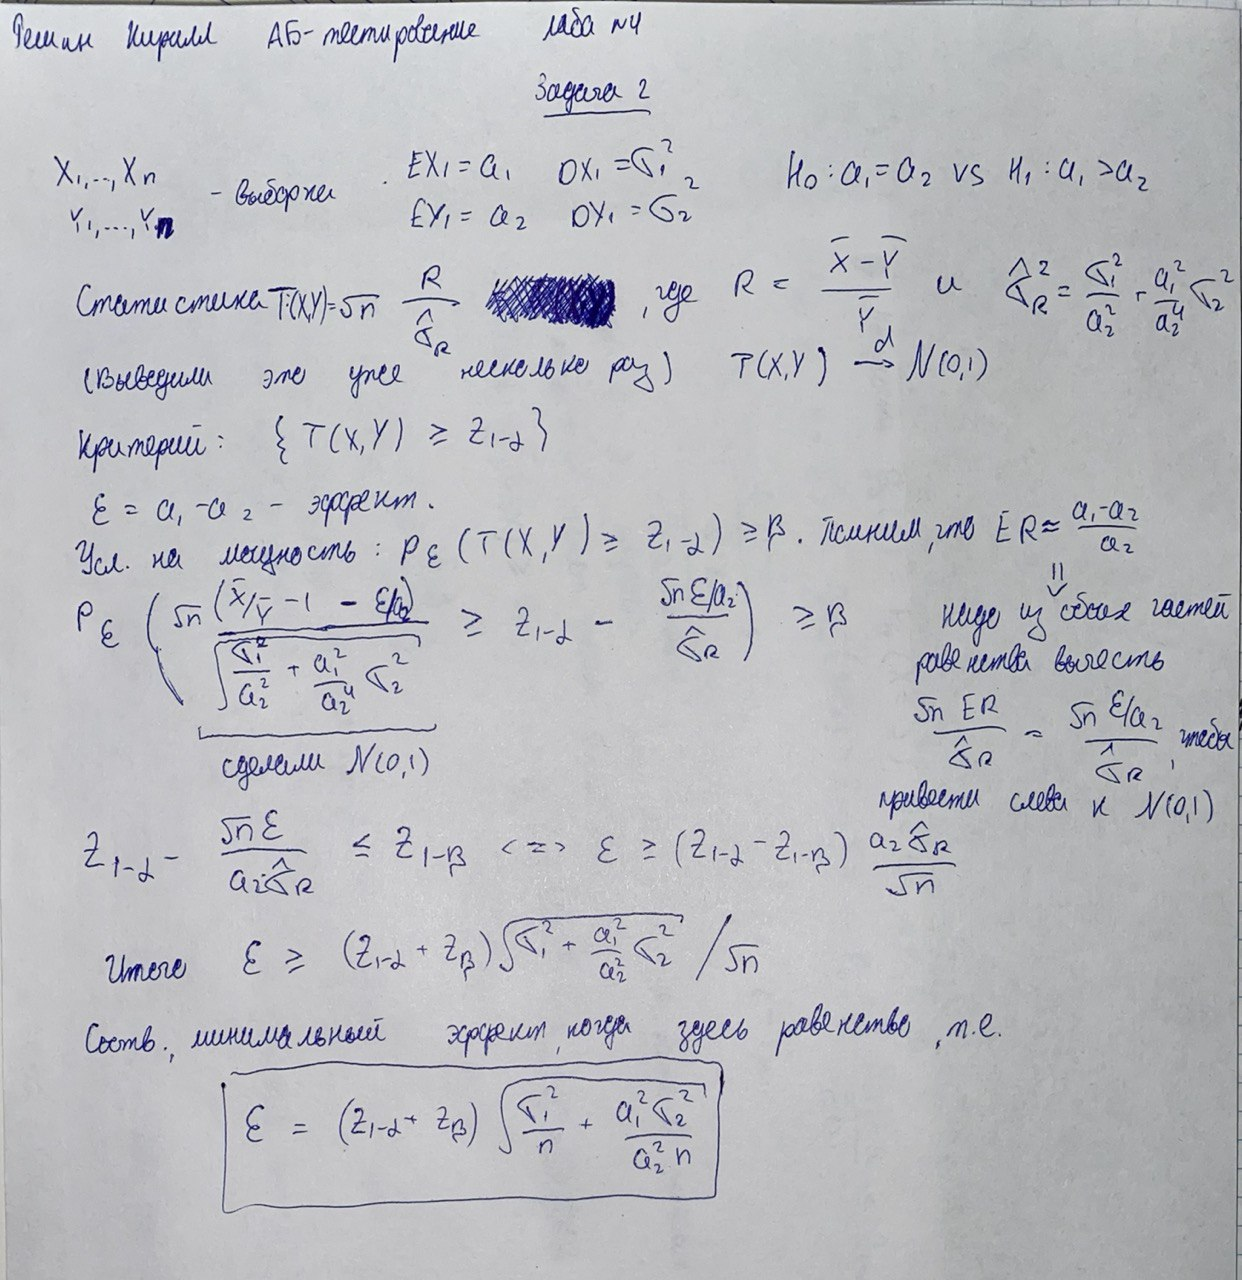

---
### Задача 3

В одной компании собираются проводить эксперимент о принятии новой фичи продукта. Перед командой аналитики стоит задача о корректном проведении AB-тестирования. У вас имеются <a href="https://disk.yandex.ru/d/QVDG9qHh9ZDBAQ">исторические данные</a> по пользователям за некоторый период. С помощью них проведите дизайн эксперимента.


Выберите или оцените каким-нибудь способом:

1. Таргет эксперимента: посещения, прибыль и тд.;

2. Максимально возможную длительность AB-эксперимента;

3. Размеры A и B групп;

4. Желаемый минимальный детектируемый эффект;

5. Статистический критерий (название / односторонний или двусторонний / связные или независимые выборки);

6. Мощность критерия.

Обоснуйте свой выбор в каждом из пунктов.

Все ли полученные показатели вас устраивают? Если нет, то какие могут быть способы их улучшить?

*Примечание.* Если кажется, что информации недостаточно, сделайте свои дополнительные предположения, коррелирующие с реальностью, и работайте с ними.

In [25]:
data = pd.read_csv('hw_ab4_task3.csv')

In [26]:
data.head()

,user_id,date,spent
0,id_0,30-10-2022,182.56
1,id_0,09-10-2022,84.54
2,id_0,20-10-2022,96.02
3,id_0,05-09-2022,51.52
4,id_0,29-05-2022,126.36


In [28]:
data.shape

(18234489, 3)

Пусть таргетом нашего эксперимента будут траты пользователей (в конце концов, нас же денюжки интересуют)) за две недели, начиная с 1 апреля (в целом, две недели - довольно стандартная длительность эксперимента, в первую неделю пользователи привыкают к изменениям, во вторую - во всю пользуются новым контентом. Апрель выбран исходя из того, что к этому месяцу можно успеть все подготовить и не затягивая начать проводить исследования!)

In [45]:
# Оставим только данные за 1-15 апреля
X = data[data.date.apply(lambda x: int(x[3:5]) == 4 and int(x[0:2]) <= 15)]
X.head()

,user_id,date,spent
20,id_0,07-04-2022,120.31
63,id_0,06-04-2022,166.52
76,id_0,08-04-2022,182.93
140,id_1,01-04-2022,402.54
154,id_1,11-04-2022,302.65


In [46]:
# Посчитаем количество уникальных пользователей:
len(X.groupby('user_id')['date'].count())

93582

Посчитаем сколько в среднем посетителей в день:

In [47]:
a = pd.DataFrame(X.groupby(by='date')['user_id'].nunique())
a.head()

,user_id
date,
01-04-2022,36805
02-04-2022,36914
03-04-2022,36777
04-04-2022,36956
05-04-2022,36859


In [48]:
a['user_id'].mean()

36874.8

Пусть нам выделили по 1000 пользователей на каждую из групп (больше, чем 2%, вполне приемлемо). В компаниях же обычно проводят сразу много экспериментов, поэтому нам не могут дать все ресурсы для одной задачи

In [51]:
# Суммируем покупки каждого из пользователей за наш период
grouped = pd.DataFrame(X.groupby('user_id')['spent'].sum())
grouped.head()

,spent
user_id,
id_0,469.76
id_1,2403.87
id_10,2049.43
id_100,1661.87
id_1000,608.53


In [52]:
len(grouped)

93582

In [53]:
spent = np.array(grouped['spent'])
min(spent), max(spent)

(10.18, 10633.829999999998)

In [ ]:
# Вот такой разброс трат у нас

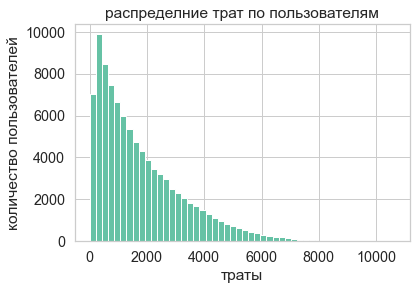

In [55]:
plt.hist(spent, bins = 50)
plt.title('распределние трат по пользователям')
plt.xlabel('траты')
plt.ylabel('количество пользователей')
plt.show()

Выбросы скорее не хотим удалять, так как видим в данном случае хвост, выбрасывание которого сильно повлияет на среднее

In [64]:
from tqdm import tqdm
from statsmodels.stats.proportion import proportion_confint

In [56]:
alpha = 0.05  # Теоретический уровень значимости
sample_size = 1_000  # Размер выборок
n_iter = 50_000  # Количество итераций валидации

In [57]:
def draw_interval(
    real_alpha, left_alpha, right_alpha, 
    alpha=0.05, figsize=(7, 2)
):
    '''
    Отрисовка интервала для реального уровня значимости
    real_alpha -- оценка уровня значимости
    left_alpha, right_alpha -- границы доверительного интервала
    alpha -- теоретический уровень значимости
    figsize -- размер фигуры matplotlib
    '''
    
    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(6, 2))
        plt.hlines(0, 0, 1, color='black', lw=2, alpha=0.6)
        plt.vlines(alpha, -1, 1, color='red', lw=5, linestyle='--', alpha=0.6)
        plt.fill_between(
            [left_alpha, right_alpha], [0.15]*2, [-0.15]*2, 
            color='green', alpha=0.6
        )
        plt.scatter(real_alpha, 0, s=300, marker='*', color='red')
        plt.xlim((min(alpha, left_alpha)-1e-3, max(alpha, right_alpha)+1e-3))
        plt.title(
            f'Доля отвержений = {100*real_alpha:.2f}%, '
            f'интервал ({100*left_alpha:.2f}%, {100*right_alpha:.2f}%)'
        )
        plt.ylim((-0.5, 0.5))
        plt.yticks([])
        plt.tight_layout()
        plt.show()

In [58]:
def calculate_real_alpha(n_errors, n_iter):
    '''
    Оценка реального уровня значимости и его дов. интервала.
    
    Аргументы:
    n_errors -- количество ошибок в эксперименте
    n_iter -- количество экспериментов
    
    Возвращает:
    real_alpha -- оценка реального уровня значимости
    left_alpha, right_alpha -- границы соотв. дов. интервала
    '''
    
    real_alpha = n_errors / n_iter
    left_alpha, right_alpha = proportion_confint(n_errors, n_iter, method='wilson')
    
    return real_alpha, left_alpha, right_alpha

In [60]:
def AA_test(
    test, n_iter=10000, sample_size=1000, alpha=0.05
):
    '''
    Проведение серии AA-тестов на искусственных выборках.
    
    Аргументы:
    test -- статистический критерий
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- теоретический уровень значимости
    '''

    n_errors = 0  # количество отвержений H_0

    # Проведение экспериментов
    for _ in tqdm(range(n_iter)):
        indices = np.random.choice(len(spent), sample_size * 2, replace=False)
        x = spent[indices[:sample_size]]
        y = spent[indices[sample_size:]]
        n_errors += test(x, y)

    # Реальный уровень значимости
    real_alpha, left_alpha, right_alpha = calculate_real_alpha(n_errors, n_iter)
    draw_interval(real_alpha, left_alpha, right_alpha, alpha=alpha)

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:38<00:00, 509.43it/s]


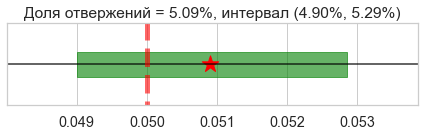

In [65]:
AA_test(
    test=lambda x, y: sps.ttest_ind(x, y)[1] < alpha,
    sample_size=sample_size,
    n_iter=n_iter,
)

В целом получили хороший результат: доверительный интервал реального уровня значимости захватывает теоретический уровень значимости, то есть такой критерий вполне применим. Попробуем посмотреть еще для правосторонней альтернативы: мы же предполагаем, что наша фича должна что-то улучшить

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:38<00:00, 507.08it/s]


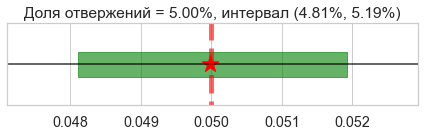

In [66]:
AA_test(
    test=lambda x, y: sps.ttest_ind(x, y, alternative='greater')[1] < alpha,
    sample_size=sample_size,
    n_iter=n_iter,
)

Ну вообще идеально, пока оставляем t-test с правосторонней альтернативой для несвязных выборок

In [72]:
def with_effect(
    test, n_iter=10000, sample_size=1000, alpha=0.05, effect = 100
):
    '''
    Проведение серии AA-тестов на искусственных выборках.
    
    Аргументы:
    test -- статистический критерий
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- теоретический уровень значимости
    '''

    n_errors = 0  # количество отвержений H_0

    # Проведение экспериментов
    for _ in tqdm(range(n_iter)):
        indices = np.random.choice(len(spent), sample_size * 2, replace=False)
        x = spent[indices[:sample_size]] + effect
        y = spent[indices[sample_size:]]
        n_errors += test(x, y)

    # Реальный уровень значимости
    real_alpha, left_alpha, right_alpha = calculate_real_alpha(n_errors, n_iter)
    draw_interval(real_alpha, left_alpha, right_alpha, alpha=alpha)

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:37<00:00, 510.67it/s]


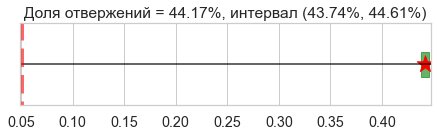

In [73]:
with_effect(
    test=lambda x, y: sps.ttest_ind(x, y, alternative='greater')[1] < alpha,
    sample_size=sample_size,
    n_iter=n_iter,
    effect = 100
)

In [ ]:
# Пока недостаточно, поробуем увеличить mde

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:38<00:00, 507.22it/s]


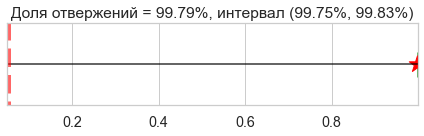

In [74]:
with_effect(
    test=lambda x, y: sps.ttest_ind(x, y, alternative='greater')[1] < alpha,
    sample_size=sample_size,
    n_iter=n_iter,
    effect = 300
)

In [ ]:
# Воу, уже слишком много даже

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:39<00:00, 502.39it/s]


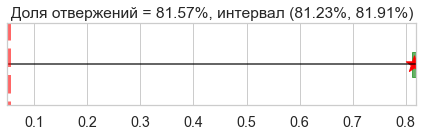

In [78]:
with_effect(
    test=lambda x, y: sps.ttest_ind(x, y, alternative='greater')[1] < alpha,
    sample_size=sample_size,
    n_iter=n_iter,
    effect = 170
)

In [ ]:
# Извиняюсь, что с выбором эффекта у меня по сути тыканье в небо, просто каждый тест и так долго работает,
# а если все это еще и в цикл запихнуть, то будет еще дольше

Итого для мощности около 80% минимальный детектируемый эффект в районе 170 для t-testа с правосторонней альтернативой и несвязными выборками

In [ ]:
# Проведем эксперимент еще с двусторонней альтернативой на всякий случай

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:38<00:00, 509.54it/s]


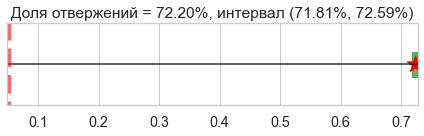

In [140]:
with_effect(
    test=lambda x, y: sps.ttest_ind(x, y)[1] < alpha,
    sample_size=sample_size,
    n_iter=n_iter,
    effect = 170
)

In [ ]:
# Итого мощноть хуже

Теперь попробуем, как на семинаре, брать одну группу случайно, а другую похожую на первую по ближайшим соседям жадным образом

В таком случае уже надо брать t-test для связных выборок

In [118]:
def nearest_object_indexes(prepilot, total_size, sample_size):
    '''
    Одну группу выбираем случайно, другую - жадным образом 
    на основе похожести по историческим данным
    
    prepilot -- не используется, нужен для совместимости
    total_size -- общее количество данных
    sample_size -- размер выборок
    '''
    
    # Выбираем тестовую группу
    b_indexes = np.random.choice(np.arange(total_size), size=sample_size, replace=False)
    
    # Выделяем индексы остальных объектов
    other_indexes = np.arange(total_size)[~np.in1d(np.arange(total_size), b_indexes)]
    
    # Считаем попарные расстояния между выбранными и остальными
    dist = pd.DataFrame(
        data=np.abs(prepilot[b_indexes, None] - prepilot[other_indexes]),
        index=b_indexes,
        columns=other_indexes
    )
    a_indexes = []

    # Для каждого объекта из тестовой группы
    for ind in (b_indexes):
        # Ищем ближайший
        nearest_object_index = dist.loc[ind].idxmin()
        # сохраняем его
        a_indexes.append(nearest_object_index)
        # удаляем из таблицы чтобы не взять его повторно
        dist.drop(nearest_object_index, axis=1, inplace=True)

    a_indexes = np.array(a_indexes)
    
    return a_indexes, b_indexes

In [135]:
def AA_test_selection(
    test, spent, generate_indexes, 
    n_iter=10000, sample_size=1000, alpha=0.05, effect=0
):
    '''
    Проведение серии AА-тестов на искусственных выборках.
    
    Аргументы:
    test -- статистический критерий
    generate_sample -- функция для семплирования общего объема данных
    generate_indexes -- функции для семплирования индексов выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- уровень значимости
    effect -- размер эффекта, который добавляем к одной из групп
    '''

    n_errors = 0  # количество отвержений H_0
    diffs = []  # разность средних

    # Проведение экспериментов
    for _ in tqdm(range(n_iter)):
        
        # Из-за того, что все очень долго работает, берем 1000 рандомных объектов, 
        # а дальше сэмплируем индексы уже только для этих элементов
        ind = np.random.choice(len(spent), size=1000, replace=False)
        prepilot = spent[ind]
        scale_factor = 0.1
        # Как на семинаре генерируем пилотную группу
        pilot1 = prepilot1 + np.random.normal(
                size=1000, 
                scale=prepilot.std() * scale_factor
            )
        
        # Семплируем индексы групп
        a_indexes, b_indexes = generate_indexes(prepilot, len(prepilot), sample_size)
        
        # Определяем группы
        x = pilot[a_indexes]
        y = pilot[b_indexes] + effect
        
        # Тестируем
        n_errors += test(x, y)
        
        # Сохраняем разность средних
        diffs.append(x.mean() - y.mean())

    # Реальный уровень значимости
    real_alpha, left_alpha, right_alpha = calculate_real_alpha(n_errors, n_iter)
    draw_interval(real_alpha, left_alpha, right_alpha, alpha=alpha)
    
    return diffs

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [50:49<00:00, 16.39it/s]


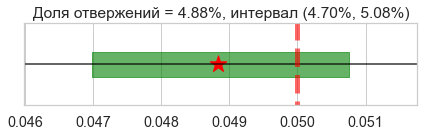

In [136]:
diffs_nearest = AA_test_selection(
    test=lambda x, y: sps.ttest_rel(x, y)[1] < alpha,
    spent=spent,
    generate_indexes=nearest_object_indexes,
    n_iter=n_iter,
    sample_size=100 # взял группы меньше, так как и так долго все работает
)

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [51:12<00:00, 16.27it/s]


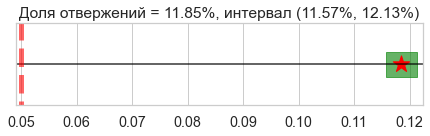

In [137]:
diffs_nearest = AA_test_selection(
    test=lambda x, y: sps.ttest_rel(x, y)[1] < alpha,
    spent=spent,
    generate_indexes=nearest_object_indexes,
    n_iter=n_iter,
    sample_size=100,
    effect=170
)

In [139]:
# Маленькаяя мощность , так как уменьшили выборку в 10 раз, значит MDE увеличилось в sqrt(10) раз
np.sqrt(10) * 170

537.5872022286245

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [51:35<00:00, 16.15it/s]


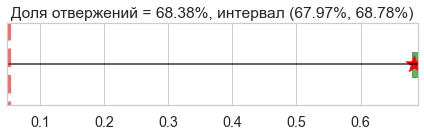

In [141]:
diffs_nearest = AA_test_selection(
    test=lambda x, y: sps.ttest_rel(x, y)[1] < alpha,
    spent=spent,
    generate_indexes=nearest_object_indexes,
    n_iter=n_iter,
    sample_size=100,
    effect=538
)

Все равно поменьше вышло, оставляем t-test с правосторонней альтернативой

Итого мы выбрали в качестве таргета прибыль за две недели с начала апреля, размеры групп 1000, минимальный детектируемый эффект 170, мощность 80% и t-test с правосторонней альтернативой.

In [142]:
(spent >= 170).sum() / len(spent) # 94% пользователей тратят больше в сумме, чем mde, что хорошо

0.9495308926930393

Если мы не можем себе позволить размеры групп по 1000, то уменьшая n в k раз, мы увеличиваем MDE в sqrt(k) раз, исходя из формулы с лекции

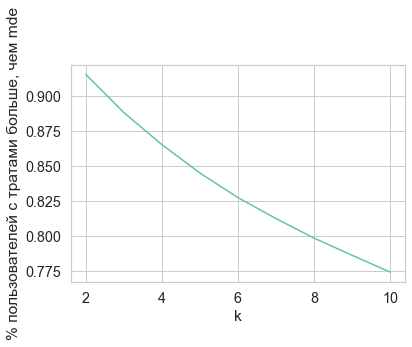

In [145]:
percents = []
for k in range(2, 11):
    percents.append((spent >= 170 * np.sqrt(k)).sum() / len(spent))
plt.plot(np.arange(2, 11), percents)
plt.xlabel('k')
plt.ylabel('% пользователей с тратами больше, чем mde')
plt.show()

In [ ]:
# Тут уже зависит от заказчика, какую выборку нам смогут предостваить

Для выбранного критерия проведите АА-тест по историческим данным, семплируя момент времени начала эксперимента и сами группы пользователей. Следите чтобы используемые интервалы времени не выходили за границы доступных данных. Если исторических данных оказалось недостаточно для вашей модели, придумайте способ решения проблемы.

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:38<00:00, 508.96it/s]


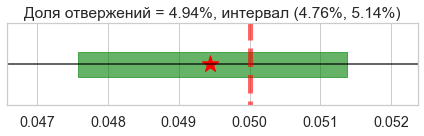

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:37<00:00, 513.92it/s]


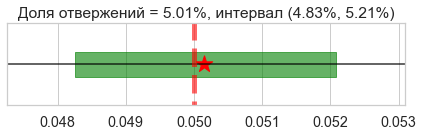

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:39<00:00, 502.38it/s]


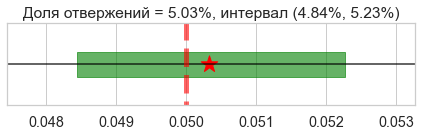

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:39<00:00, 503.79it/s]


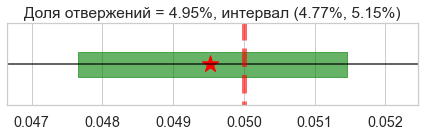

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:38<00:00, 506.69it/s]


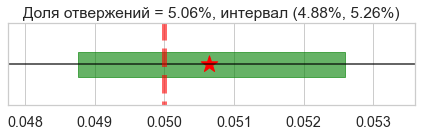

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:38<00:00, 507.45it/s]


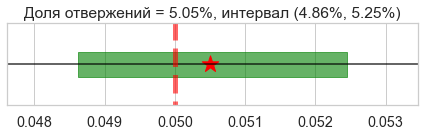

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:38<00:00, 508.97it/s]


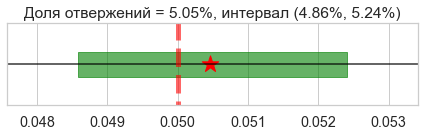

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:38<00:00, 508.08it/s]


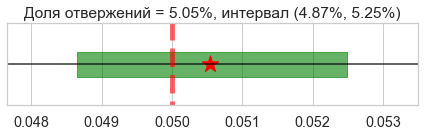

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:36<00:00, 516.51it/s]


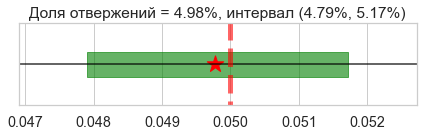

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:38<00:00, 509.41it/s]


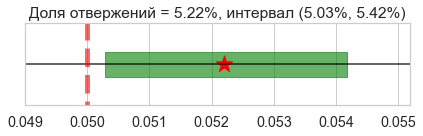

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:40<00:00, 496.29it/s]


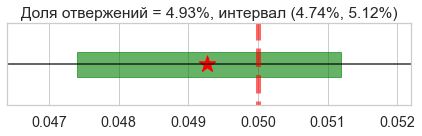

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:37<00:00, 515.41it/s]


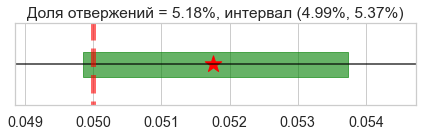

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:37<00:00, 511.98it/s]


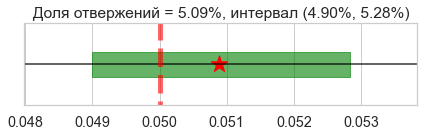

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:37<00:00, 511.63it/s]


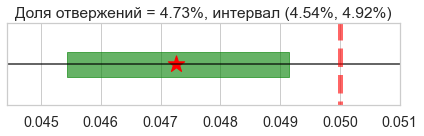

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:38<00:00, 508.30it/s]


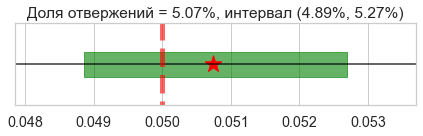

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:39<00:00, 503.61it/s]


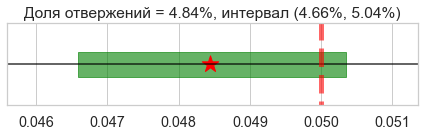

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:39<00:00, 502.18it/s]


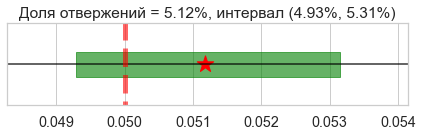

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:37<00:00, 515.44it/s]


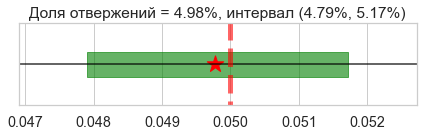

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:34<00:00, 527.13it/s]


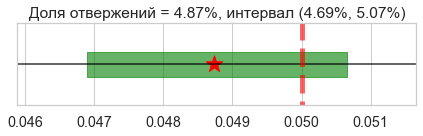

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:34<00:00, 527.16it/s]


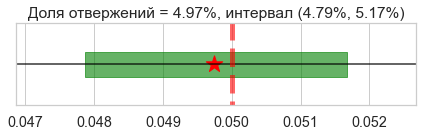

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:37<00:00, 515.19it/s]


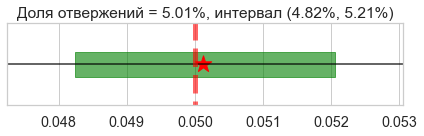

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:38<00:00, 510.04it/s]


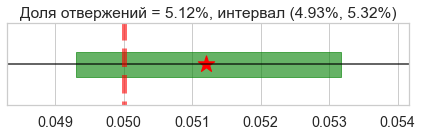

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:38<00:00, 505.53it/s]


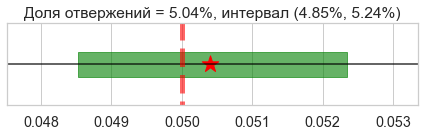

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:39<00:00, 501.32it/s]


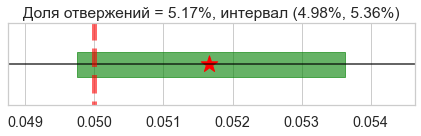

In [149]:
for i in range(2): # певая или вторая половина месяца
    for month in range(1, 13): # сам месяц
        X = data[data.date.apply(lambda x: int(x[3:5]) == month and 14 * i <= int(x[0:2]) < 15 + 14 * i )]
        grouped = pd.DataFrame(X.groupby('user_id')['spent'].sum())
        spent = np.array(grouped['spent'])
        sample_size = 1000
        AA_test(
            test=lambda x, y: sps.ttest_ind(x, y, alternative='greater')[1] < alpha,
            sample_size=sample_size,
            n_iter=n_iter,
        )

Видно, что в зависимости от периода, мы получаем разные результаты, например, для второй половины мая рельный уровень значимости 5.22% и доверительный интервал не захватывает 5%, для второй половины июля вообще реальный уровень значимости ниже 5% (4.73%) без захвата доверительным интервалом реального уровня значимости. То есть всегда стоит обращать внимание на то, какой сейчас сезон